# Introduction
The hypothetical Film Junky Union, a self-proclaimed edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews by receiving raw text as input. We have been provided a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

To avoid intensive resource consumption we will not be using BERT in this task, and attempt to achieve an F1 of at least 0.85 using other models.

## Initialization

In [1]:
# Statistical libraries
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import lightgbm as lgb

import spacy
import en_core_web_sm # unnecessary, but safety measure to ensure linkage of spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords

# Graphing and helper libraries
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn
import copy

c:\Users\brian\anaconda3\envs\DSPortfolio\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

seaborn.set_theme()

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()
display(df_reviews.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


### Clean Data

In [6]:
# Check duplicates
df_reviews[df_reviews.duplicated()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx


In [7]:
# We will ignore end_year, but we would like to convert runtime_minutes into a value we can use. We will coerce errors:
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')

In [8]:
# We want to fill missing values with median values for their title_type. First we calculate medians for each title_type:
median_title_lengths = df_reviews.groupby('title_type')['runtime_minutes'].median()
display(median_title_lengths)

title_type
movie            98.0
short            11.0
tvEpisode        57.0
tvMiniSeries    183.0
tvMovie          94.0
tvSeries         30.0
tvShort          30.0
tvSpecial        89.0
video            88.0
videoGame       130.0
Name: runtime_minutes, dtype: float64

In [9]:
# Then we fill the NaN values looping over unique title types
for i, v in median_title_lengths.items():
    cndtn = (df_reviews['runtime_minutes'].isna()) & (df_reviews['title_type'] == i)
    df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].where(~cndtn, median_title_lengths[i])

In [10]:
# Strip null
df_reviews = df_reviews.dropna().copy()

### Manage Features, Encoding

We will finalize our data by encoding our categorical features using the OrdinalEncoder encoder and adding a column. We will later pass column names to ensure we are passing the desired feature to our models, and simply leave both encoded and unencoded features in the dataframe.

In [11]:
# Set critical features for passing to models
feat_cols = [
    'le_title_type', 
    'start_year',
    'runtime_minutes', 
    'is_adult', 
    'le_genres', 
    'average_rating',
    'votes'
]

# Of these features, some need to be label-encoded as they are categorical
cat_cols = [
    'title_type',
    'genres'
]
le_cols = [
    'le_title_type',
    'le_genres'
]

In [12]:
encoder = OrdinalEncoder(dtype=np.int64)
label_encoded = pd.DataFrame(
    encoder.fit_transform(df_reviews[cat_cols]), 
    columns=le_cols
)
df_reviews = df_reviews.join(label_encoded)

In [13]:
# Final cleaned dataframe info
df_reviews.info()
df_reviews.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  float64
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
 17  le_title_type    

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,le_title_type,le_genres
0,tt0068152,movie,$,$,1971,\N,121.0,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,0.0,263.0
1,tt0068152,movie,$,$,1971,\N,121.0,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,0.0,263.0
2,tt0313150,short,'15','15',2002,\N,25.0,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,1.0,288.0
3,tt0313150,short,'15','15',2002,\N,25.0,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,1.0,288.0
4,tt0313150,short,'15','15',2002,\N,25.0,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,1.0,288.0
5,tt0313150,short,'15','15',2002,\N,25.0,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282,1.0,288.0
6,tt0313150,short,'15','15',2002,\N,25.0,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283,1.0,288.0
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88.0,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,0.0,451.0
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88.0,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,0.0,451.0
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88.0,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,0.0,451.0


## EDA

Let's check the number of movies and reviews over years.

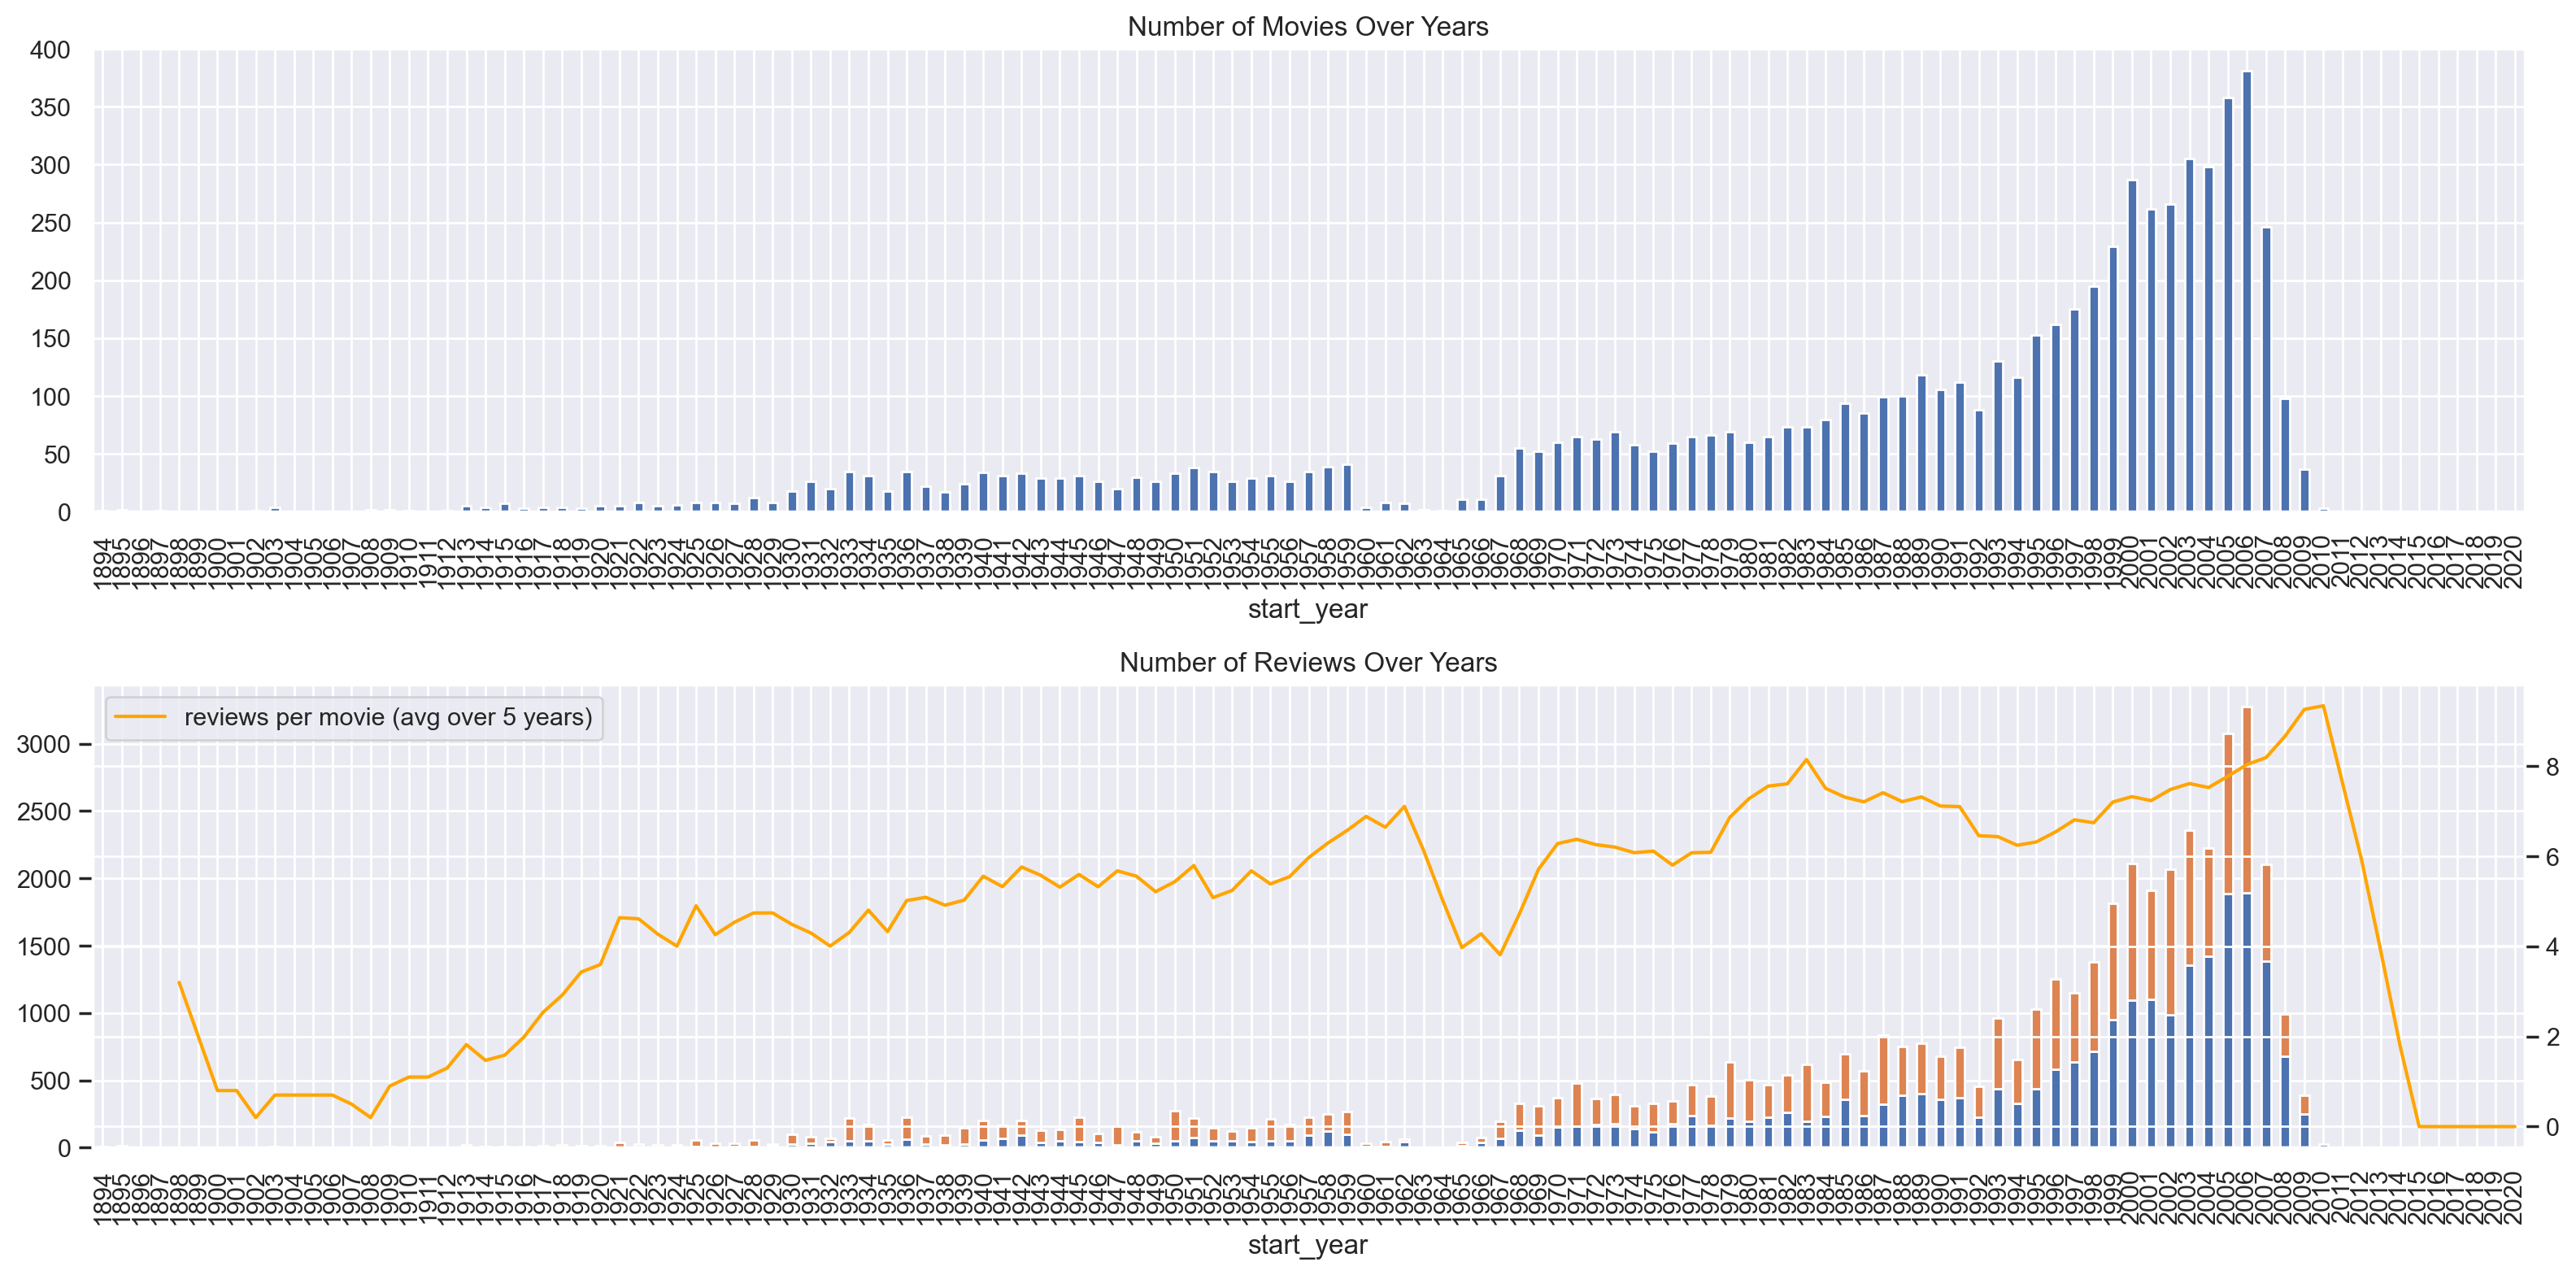

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

As the movie industry expanded, so too did the number of movies. Importantly for our analysis, from about 1920 to 2010, the total number of reviews generally correlates to the rise in the number of movies, which results in a roughly even average number of reviews per movie. The average reviews per movie (orange line above) fluxuates over the years with a gradual positive trend from around 4.5 reviews per movie in 1920 to 9 reviews per movie by 2010.

There is a peculiar drop both in total movies and average reviews per movie during the early- to mid-1960s, likely due to shifting laws and policies surrounding movie content. The dataset for iMDB drops off beginning in 2006, presumably due to database changes.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

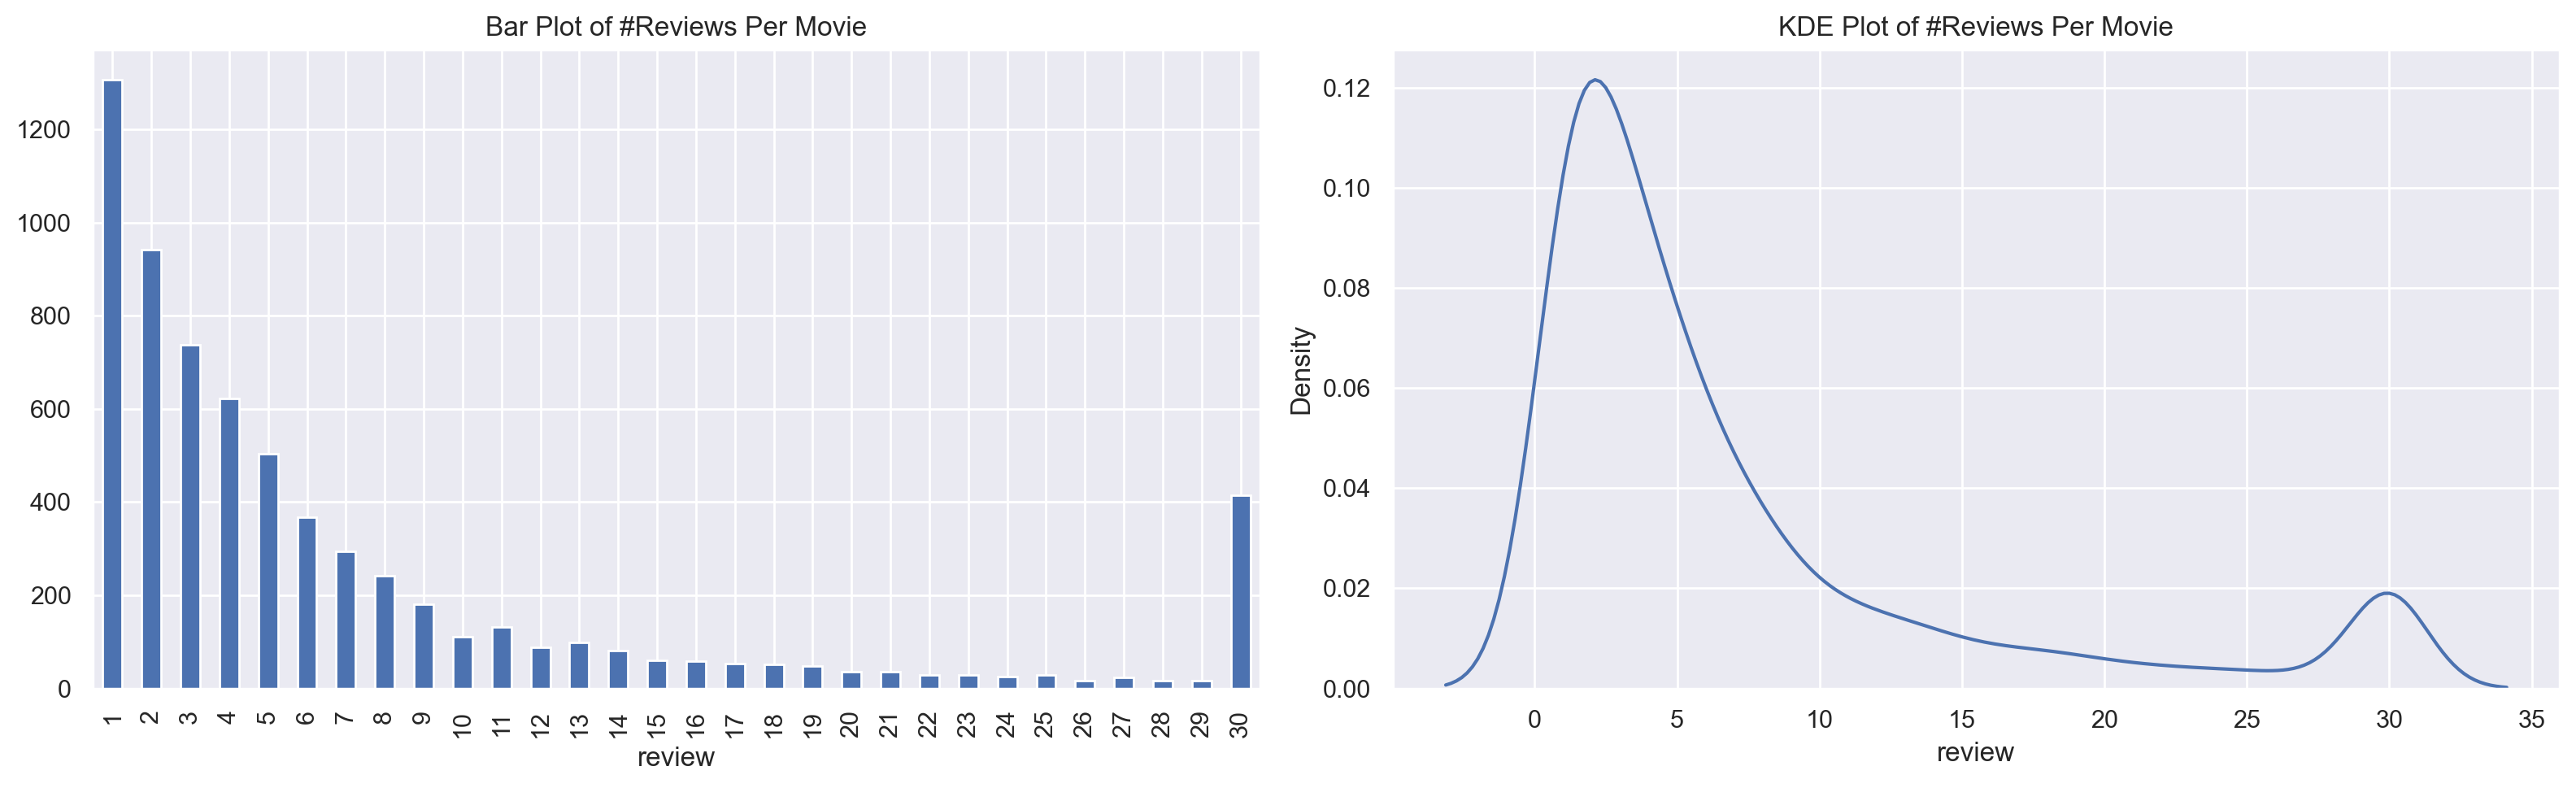

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
seaborn.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

There is a heavy right skew to the data, compounded by outliers at the 30+ review mark. It is likely that in a database such as iMDB, there are plenty of either old or indie movies appearing in the dataset which do not reach mainstream coverage, and will only have a few reviews. It is very easy to get one or two reviews for a movie; it is harder to devote the time and energy of publishing many reviews for unpopular or irrelevant (i.e. old) movies. 

We should look at how positive review distribution compares to negative review distribution to see if one or the other accounts for the above peaks. It is likely that negative reviews more strongly account for the low-review and high-review peaks due to negativity biases in audiences.

In [16]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

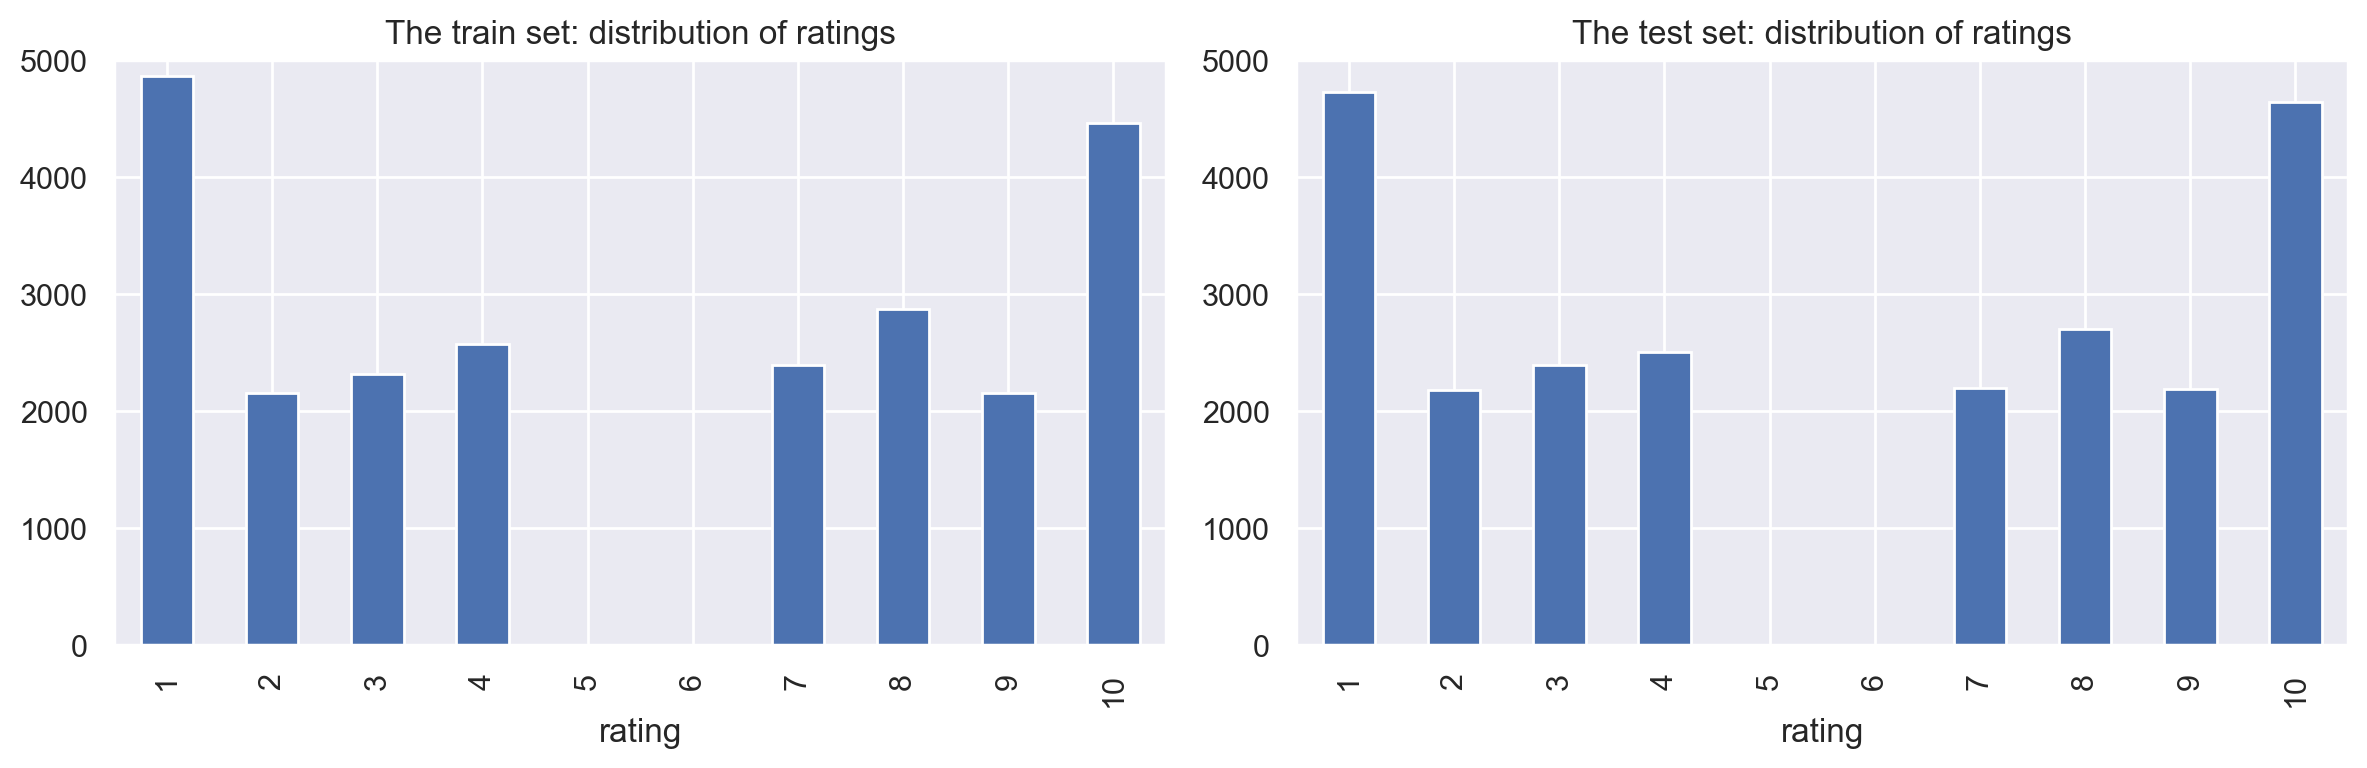

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Unsurprisingly, reviewers tend to think categorically, which for our purposes of training a classification model works out very well. There are no middle-of-the-road reviews of 5 or 6 in either subset, which is admittedly suspect from the get-go. Regardless, reviews have peaks at 1 and 10 because reviewers often favor categorizing movies with an intention to signal to others the quality of a movie. An 8 is a fair review; a 10 sends a signal. A 3 is fair, but a 1 warns others away from the movie. Extremes are more common in reviews of any kind due to signaling. This dataset therefore is an accurate reflection of the way humans review content despite the perhaps worrying ommission of reviews resulting in 5 and 6. This is most reasonably an intentional filter from the database request for this task to omit inherently neutral reviews.

We can look at the distribution of negative and positive reviews over the years for two parts of the dataset:

C:\Users\brian\AppData\Local\Temp\ipykernel_16900\2056688445.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\brian\AppData\Local\Temp\ipykernel_16900\2056688445.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\brian\AppData\Local\Temp\ipykernel_16900\2056688445.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\brian\AppData\Local\Temp\ipykernel_16900\2056688445.py:31: UserWarning: 

S

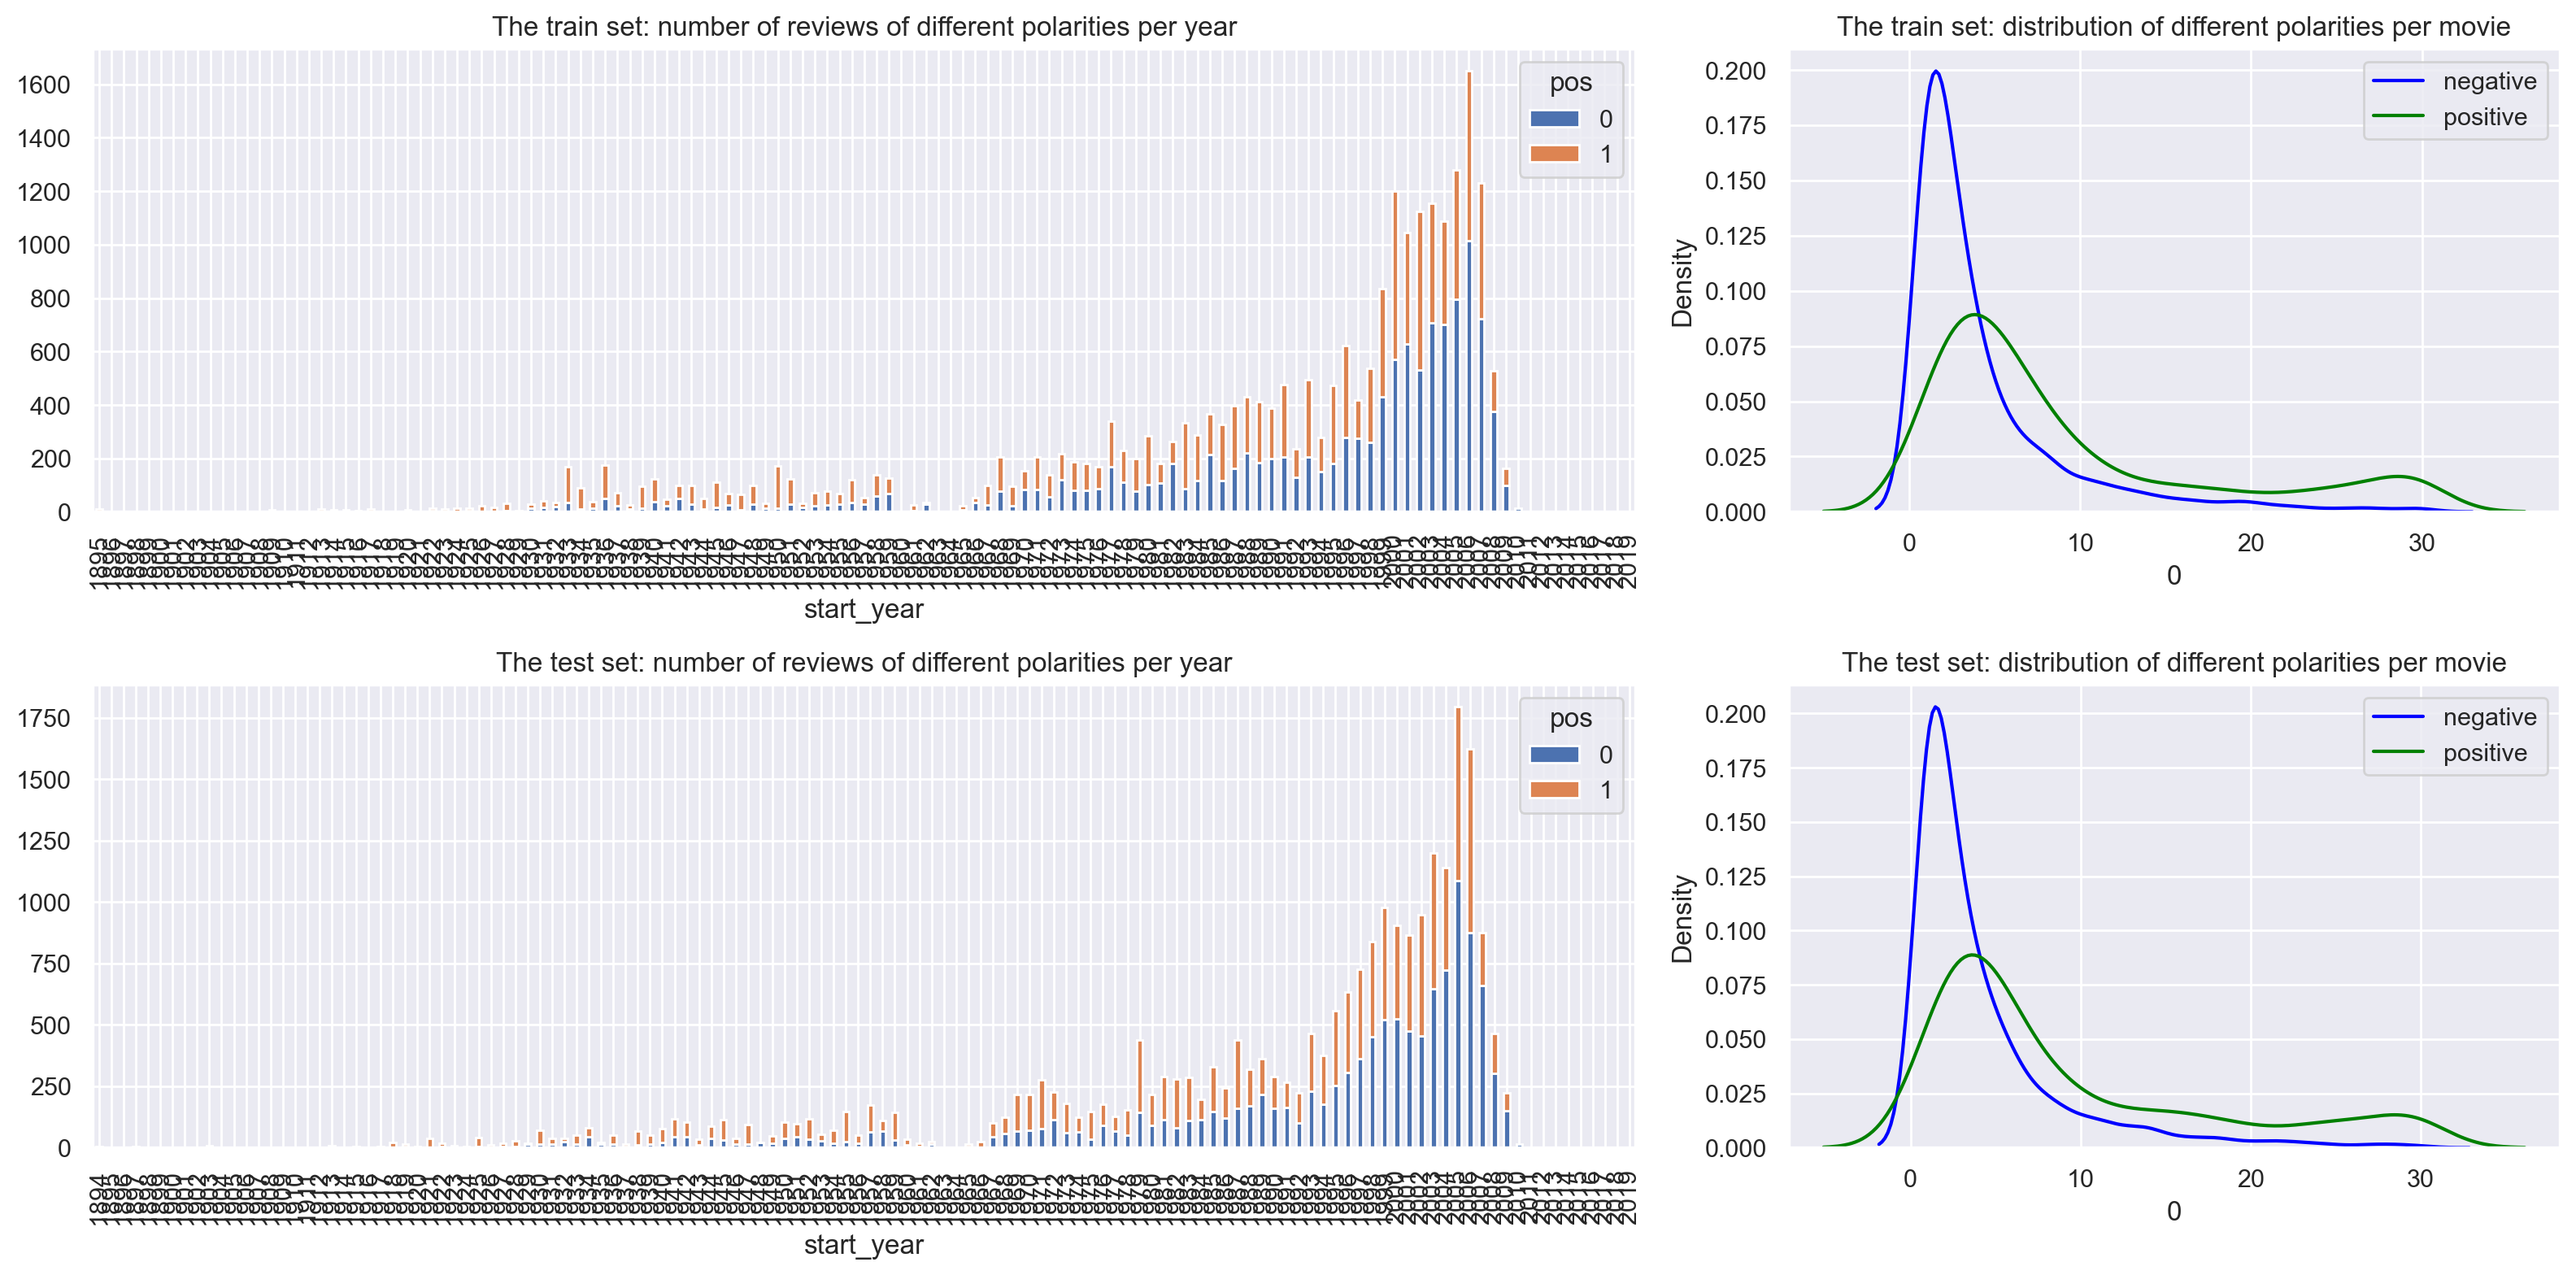

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
seaborn.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
seaborn.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
seaborn.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
seaborn.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

We have an even distribution of our target classes and do not need to account for imbalance. However, the above graphs show that the distribution of positive reviews per movie is more even. Negative reviews tend to only come in batches of 3 or fewer reviews per movie and are unlikely to ever reach over 15 reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [19]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [20]:
def clear_text(text):
    return " ".join(re.sub(r"[^a-zA-Z']", " ", text).split()).lower()

In [21]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23533, 20)


## Working with models

### Model 1 - Constant

In [23]:
train_features = df_reviews_train[feat_cols]
test_features = df_reviews_test[feat_cols]

In [24]:
model_1 = DummyClassifier(strategy='uniform')
model_1.fit(train_features, train_target)

DummyClassifier(strategy='uniform')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


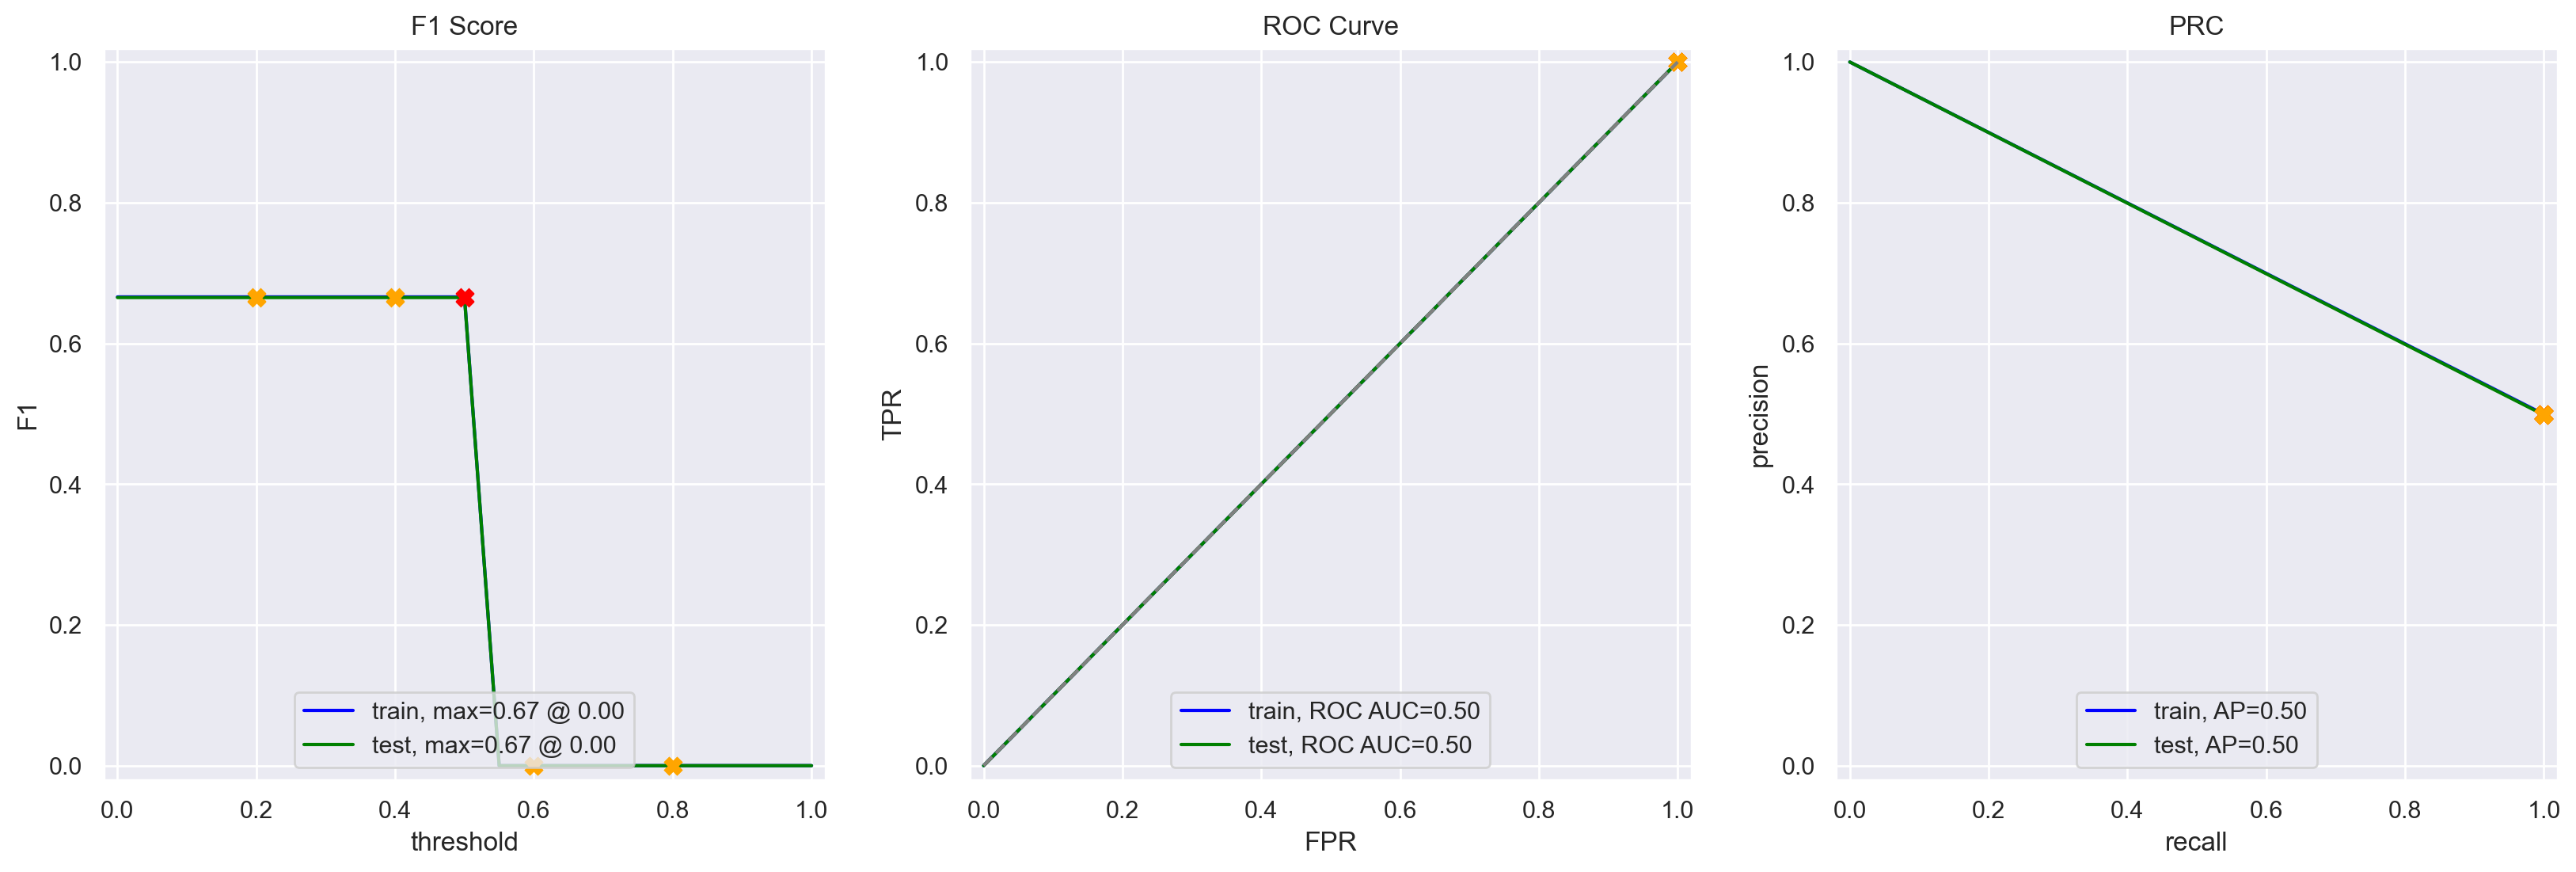

In [25]:
evaluate_model(model_1, train_features, train_target, test_features, test_target)

As expected, a dummy model is accurate 50% of the time on a classification task involving two evenly-distributed target classes. It is good to see that the train and test sets perform identically.

## Model 2 - NLTK, TF-IDF and LR

In [26]:
# Init NLTK stopwords and TF-IDF vectorizer
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Vectorize
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])

In [28]:
model_2 = LogisticRegression(
    random_state=12345
)
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


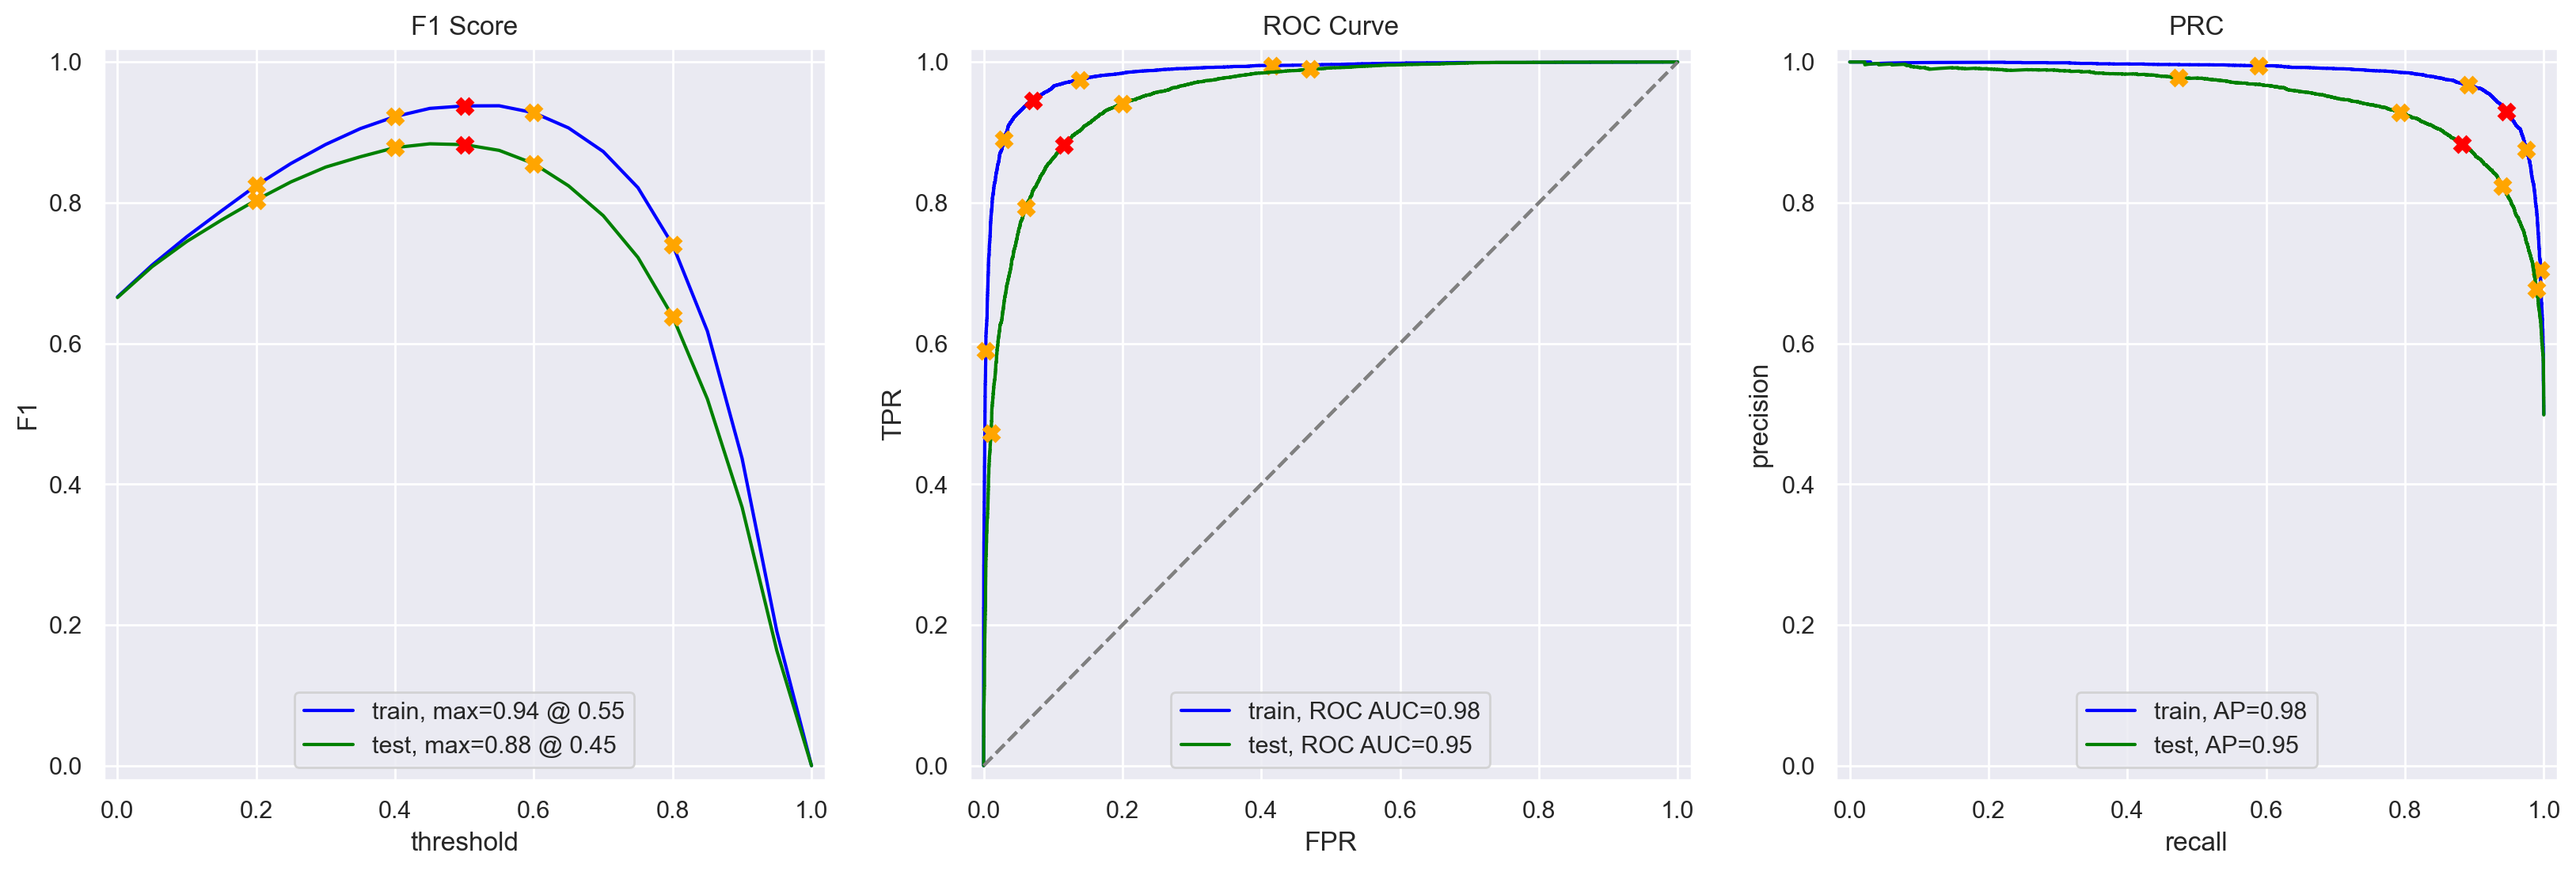

In [29]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

A simple linear classification model performed very well using NLTK stopwords when generating a TF-IDF matrix. A test set should always perform slightly worse than the training set, and the margin here is within reasonable limits. At a threshold of 0.45 the classification model can accurately predict 88% of the test set's target classification. There is a strong balance of recall and precision, where we can afford to have high recall (did the model find all positive results) and high precision (did the model have low false positivity).

### Model 3 - spaCy, TF-IDF and LR

In [30]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
# Vectorize
tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm'].apply(text_preprocessing_3))
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm'].apply(text_preprocessing_3))

In [33]:
model_3 = LogisticRegression(
    random_state=12345
)
model_3.fit(train_features_3, train_target)

c:\Users\brian\anaconda3\envs\DSPortfolio\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


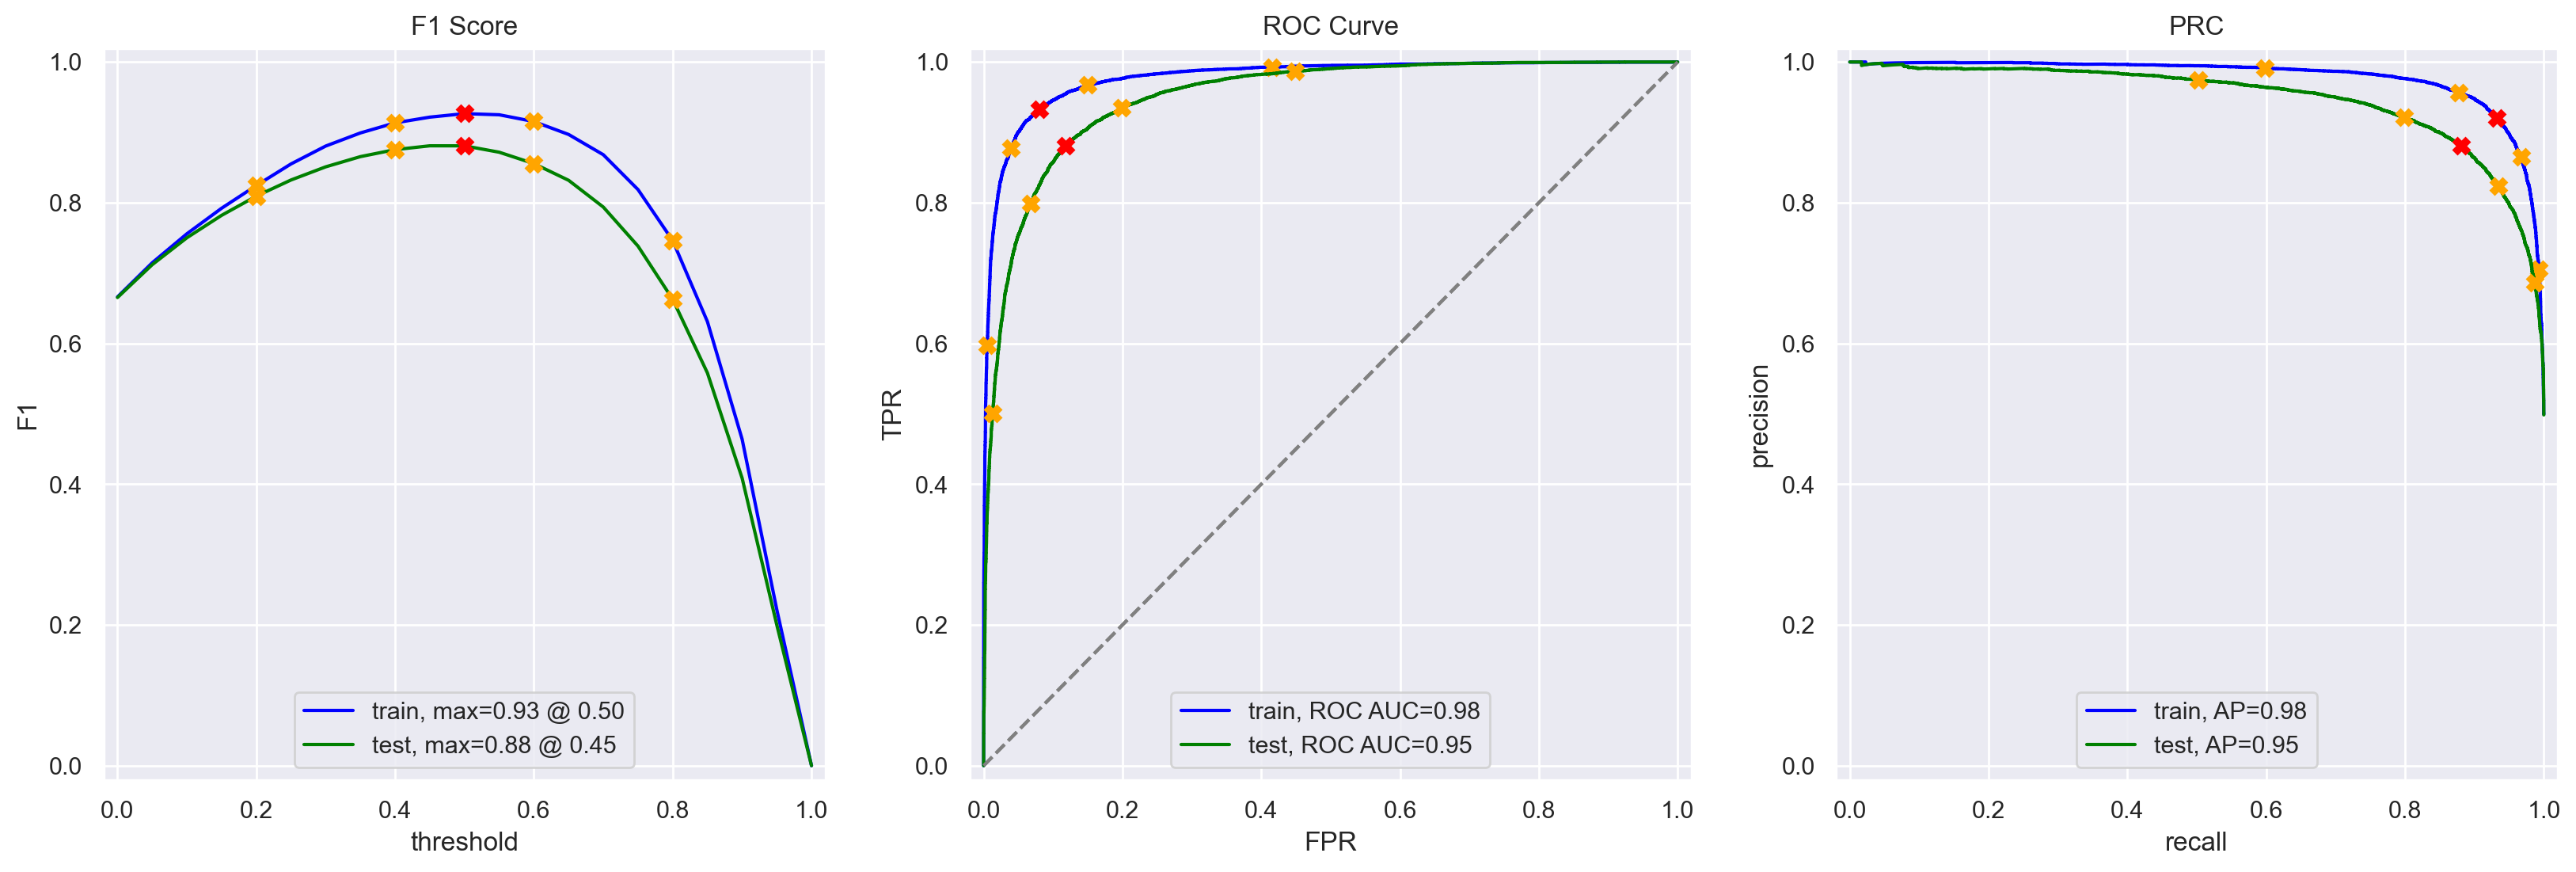

In [34]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Changing the TF-IDF vectorization to using SpaCy lemmatization had no significant effect on the performance of the model. The above curves and metrics are virtually identical to the previous model's. We are not using n-gram matrices, but rather measuring the appearance of single words and their correlation to positivity in reviews. This is a potential reason for seeing no difference between NLTK and SpaCy vectorization. 

We should now change the underlying model to control for model choice.

In [35]:
# Bit of cleanup to prevent kernal death
train_features_4 = copy.copy(train_features_3)
test_features_4 = copy.copy(test_features_3)

del train_features_3, test_features_3, train_features_2, test_features_2

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [36]:
# Vectorizer
tfidf_vectorizer_4 = copy.copy(tfidf_vectorizer_3)

In [37]:
# Set params for LGBM
params = {
    'random_state': 12345,
    'n_jobs': -1,
    'num_leaves': 90,
    'max_depth': 15,
    'subsample': 0.8,
    'learning_rate': 0.1
}

model_4 = lgb.LGBMClassifier(**params)

In [38]:
model_4.fit(train_features_4, train_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 481092
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(max_depth=15, n_jobs=-1, num_leaves=90, random_state=12345,
               subsample=0.8)

          train  test
Accuracy   0.97  0.85
F1         0.97  0.85
APS        1.00  0.93
ROC AUC    1.00  0.93


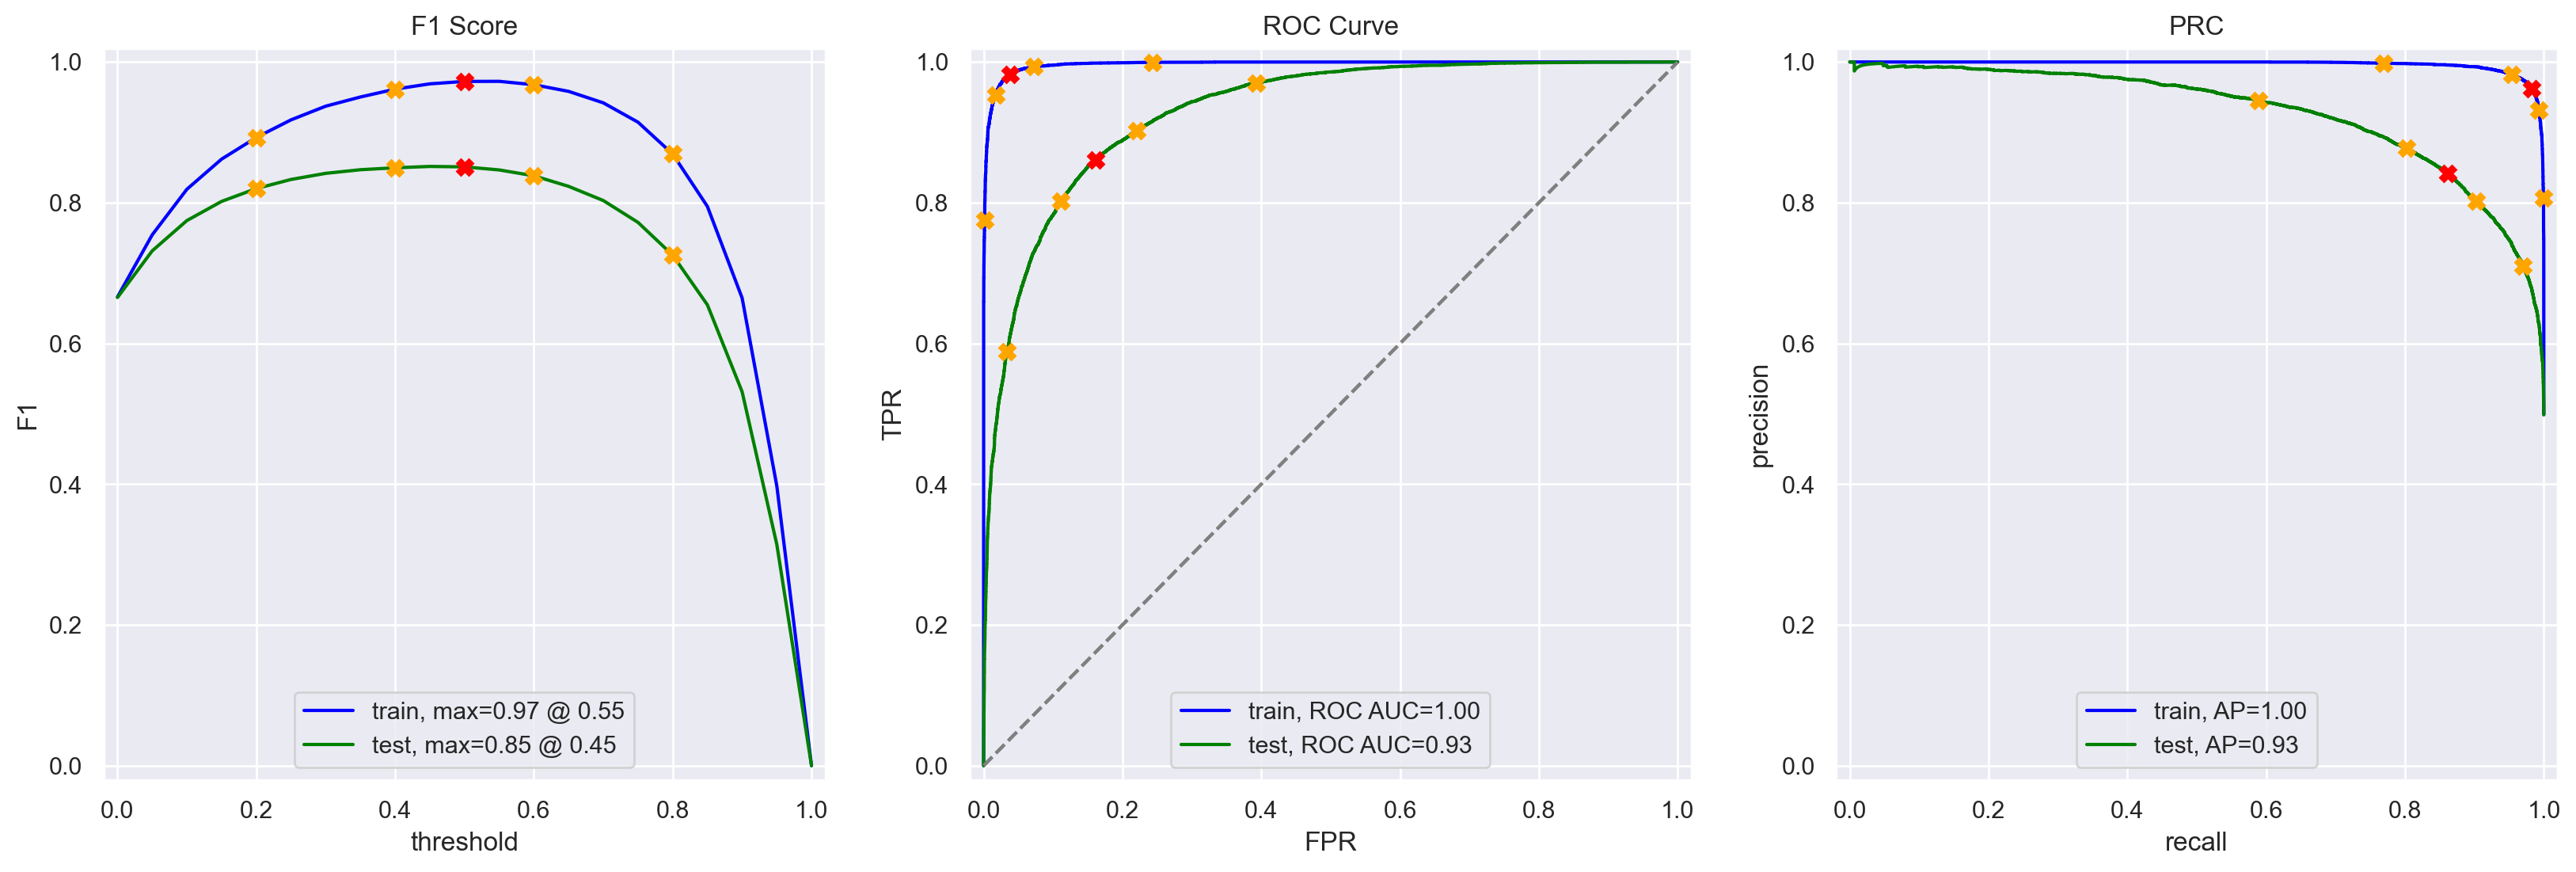

In [39]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

Our graphs have now changed in a significant way when evaluating our LGBM model, primarily in an overfitting manner. The ROC curve is absurdly high for the training set, while the test set curve is actually lower compared to prior models. Such a gap between training set and test set performance indicates overfitting of the model. The model only performed mildly worse compared to Linear Classification for the test set, still indicating an effective model for predicting cases. Still, future models should tweak hyperparameters to better control for overfitting. As it stands, an F1 score of 0.85 exactly meets our threshold for our model, and any worse and we would need to reject the model.

We can see the predict_proba values for each of these models for each of a few sample cases to better understand how these models classify text as positive or negative. We will do that below.

## My Reviews

In [40]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

display(my_reviews)

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn't expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.64:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.65:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didn't expect the reboot to be so good writers really cared about the source material
0.79:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.28:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.75:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

The two logistic classifier models performed comparably both on the test set (with nearly identical evaluation metrics) and when parsing custom, novel reviews in the above section. This indicates that the uncommon denominator, the method used to create the TF-IDF vectors, did not yield a significant difference. On this task, SpaCy and NLTK performed similarly. 

We might expect performance between these two to diverge more when experimenting with different-sized n-grams. This particular task created vectors parsing single word frequency, meaning that the models simply learned which words correlated with positive or negative reviews.

The last model utilized the LGBM libraries and performed slightly worse. The reason why is clear in the performance metrics on the training set; the model achieved metrics such as F1 and AUC-ROC equal to 1. This is almost always an indication of overfitting to the training set. Tweaking hyperparameters further could yield a superior result.